**Import required libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import string



import numpy as np 
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
import re

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
!pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 61kB 2.1MB/s 


**Read Dataset**

In [ ]:
train=pd.read_csv("/content/drive/My Drive/DataSets/archive/Corona_NLP_train.csv",encoding='latin1');
test=pd.read_csv("/content/drive/My Drive/DataSets/archive/Corona_NLP_test.csv",encoding='latin1');

df = train.append(test, sort = False)

df.head()

df


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


**Data Pre-processing (Cleaning, Tokenization)**

In [ ]:
tweet = df['OriginalTweet'].copy()
senti = df['Sentiment'].copy()

print(tweet.shape)
print(senti.shape)

#data cleaning
def clean_data(tweet):

  tweet = str(tweet).lower() #lowercase
  tweet = re.sub('\[.*?\]', '', tweet) #brackets
  tweet = re.sub('https?://\S+|www\.\S+', '', tweet) #URLs
  tweet = re.sub('<.*?>+', '', tweet) #punctuation
  tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet) #punctuation
  tweet = re.sub('\n', '', tweet) #punctuation
  tweet = re.sub('\w*\d\w*', '', tweet) #punctuation
  return tweet

tweet_cleaned = tweet.apply(clean_data)
tweet_cleaned.head()


#tokenize the tweets
tok = Tokenizer()
tok.fit_on_texts(tweet_cleaned)

tweet = tok.texts_to_sequences(tweet_cleaned)

vocab_size = len(tok.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(tweet_cleaned[6]))
print("\nAfter tokenizing :\n{}".format(tweet[6]))



tweet = pad_sequences(tweet, padding='post')
print("\nAfter padding :\n{}".format(tweet[6]))
print(tweet.shape)
print(senti[7])

(44955,)
(44955,)
Vocabulary size: 74791

Example:

Sentence:
6    cashier at grocery store was sharing his insig...
6    voting in the age of coronavirus  hand sanitiz...
Name: OriginalTweet, dtype: object

After tokenizing :
[1189, 14, 21, 18, 69, 1420, 249, 800, 11, 2, 3042, 249, 11597, 188, 11598, 193, 6, 24892, 1597, 52, 13, 127, 63, 193, 961, 57]

After padding :
[ 1189    14    21    18    69  1420   249   800    11     2  3042   249
 11597   188 11598   193     6 24892  1597    52    13   127    63   193
   961    57     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
(44955, 61)
7    Neutral
7    Neutral
Name: Sentiment, dtype: object


# **HyperModel Initialization and Structure**

In [ ]:
def model_builder(hp):
 
  embed_dim = 16

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 8, max_value = 256, step = 8)
  hp_drop = hp.Float('dropout', min_value=0, max_value=0.7, step=0.1)



  model = tf.keras.Sequential([
    L.Embedding(vocab_size, embed_dim, input_length=tweet.shape[1]),
    L.SimpleRNN(hp_units,return_sequences=True),
    L.GlobalMaxPool1D(),
    L.Dropout(hp_drop),
    L.Dense(64, activation="relu"),
    L.Dropout(hp_drop),
    L.Dense(5)
  ])

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model.compile(optimizer = Adam(learning_rate = 0.001),
                loss = SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])

  return model

tuner = kt.Hyperband(model_builder, objective = 'val_accuracy', max_epochs = 5, factor = 2, directory = '/content/drive/My Drive/DataSets/hyper', project_name = 'hp_search') 



INFO:tensorflow:Reloading Oracle from existing project /content/drive/My Drive/DataSets/hyper/hp_search/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/My Drive/DataSets/hyper/hp_search/tuner0.json


In [ ]:

encoder = LabelEncoder()
df['encoded_sentiment'] = encoder.fit_transform(df['Sentiment'])
senti = df['encoded_sentiment']

t_train, t_test, s_train, s_test = train_test_split(tweet,senti, test_size=0.3,stratify=senti)
print(t_train.shape,s_train.shape)
print(t_test.shape,s_test.shape)

tuner.search(t_train, s_train, epochs = 10, validation_data = (t_train, s_train))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

(31468, 61) (31468,)
(13487, 61) (13487,)
Epoch 1/10
984/984 [==============================] - 91s 92ms/step - loss: 1.5885 - accuracy: 0.2642 - val_loss: 1.5799 - val_accuracy: 0.2751
Epoch 2/10
984/984 [==============================] - 90s 91ms/step - loss: 1.5773 - accuracy: 0.2751 - val_loss: 1.5764 - val_accuracy: 0.2751
Epoch 3/10
984/984 [==============================] - 89s 90ms/step - loss: 1.5772 - accuracy: 0.2751 - val_loss: 1.5760 - val_accuracy: 0.2751
Epoch 4/10
984/984 [==============================] - 91s 92ms/step - loss: 1.5768 - accuracy: 0.2751 - val_loss: 1.5778 - val_accuracy: 0.2751
Epoch 5/10
984/984 [==============================] - 92s 93ms/step - loss: 1.5770 - accuracy: 0.2751 - val_loss: 1.5762 - val_accuracy: 0.2751
Epoch 6/10
984/984 [==============================] - 89s 91ms/step - loss: 1.5768 - accuracy: 0.2751 - val_loss: 1.5771 - val_accuracy: 0.2751
Epoch 7/10
984/984 [==============================] - 89s 91ms/step - loss: 1.5767 - accuracy:

Epoch 1/10
984/984 [==============================] - 117s 119ms/step - loss: 1.5919 - accuracy: 0.2649 - val_loss: 1.5774 - val_accuracy: 0.2751
Epoch 2/10
984/984 [==============================] - 114s 116ms/step - loss: 1.5772 - accuracy: 0.2750 - val_loss: 1.5760 - val_accuracy: 0.2751
Epoch 3/10
984/984 [==============================] - 114s 116ms/step - loss: 1.5761 - accuracy: 0.2746 - val_loss: 1.5758 - val_accuracy: 0.2751
Epoch 4/10
984/984 [==============================] - 114s 116ms/step - loss: 1.5760 - accuracy: 0.2749 - val_loss: 1.5757 - val_accuracy: 0.2751
Epoch 5/10
984/984 [==============================] - 115s 116ms/step - loss: 1.5759 - accuracy: 0.2749 - val_loss: 1.5758 - val_accuracy: 0.2751
Epoch 6/10
984/984 [==============================] - 111s 113ms/step - loss: 1.5760 - accuracy: 0.2751 - val_loss: 1.5758 - val_accuracy: 0.2751
Epoch 7/10
984/984 [==============================] - 113s 114ms/step - loss: 1.5760 - accuracy: 0.2751 - val_loss: 1.5758 -

In [1]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



NameError: ignored

In [ ]:
model = tuner.hypermodel.build(best_hps)
model.fit(t_train, s_train, epochs = 10, validation_data = (t_test, s_test))

Epoch 1/10
984/984 [==============================] - 22s 23ms/step - loss: 1.5583 - accuracy: 0.2800 - val_loss: 1.4791 - val_accuracy: 0.3084
Epoch 2/10
984/984 [==============================] - 23s 23ms/step - loss: 1.2613 - accuracy: 0.4579 - val_loss: 0.9982 - val_accuracy: 0.6074
Epoch 3/10
984/984 [==============================] - 23s 23ms/step - loss: 0.9114 - accuracy: 0.6363 - val_loss: 0.8853 - val_accuracy: 0.6584
Epoch 4/10
984/984 [==============================] - 22s 23ms/step - loss: 0.7018 - accuracy: 0.7297 - val_loss: 0.9048 - val_accuracy: 0.6617
Epoch 5/10
984/984 [==============================] - 23s 23ms/step - loss: 0.5521 - accuracy: 0.7939 - val_loss: 1.0140 - val_accuracy: 0.6606
Epoch 6/10
984/984 [==============================] - 23s 23ms/step - loss: 0.4543 - accuracy: 0.8313 - val_loss: 1.0003 - val_accuracy: 0.6368
Epoch 7/10
984/984 [==============================] - 25s 26ms/step - loss: 0.3659 - accuracy: 0.8697 - val_loss: 1.0563 - val_accuracy:

Test loss: 1.3362056016921997
Test Accuracy: 0.6467709541320801


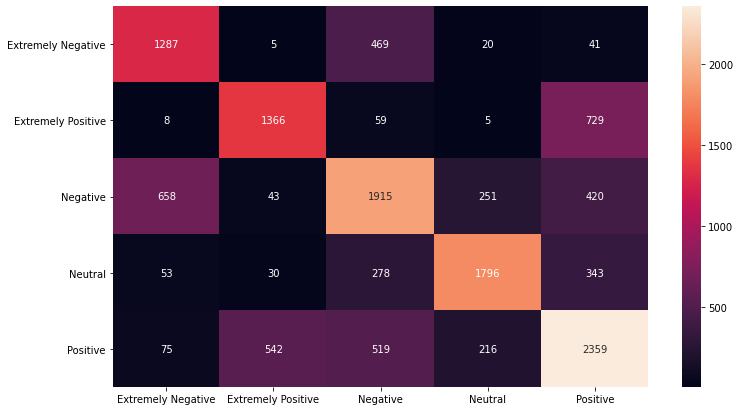

In [ ]:
#test the test data
pred = np.argmax(model.predict(t_test), axis=-1)


loss, acc = model.evaluate(t_test,s_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

conf = confusion_matrix(s_test, pred)

cm = pd.DataFrame(conf, index = list(encoder.classes_), columns = list(encoder.classes_))

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [ ]:
from sklearn import metrics
labels = 
print(metrics.classification_report(t_test, s_test, target_names = encoder.fit))

SyntaxError: ignored